# Faster hyperboloid decision trees
> Just use `scikit-learn`!

This notebook demonstrates a faster implementation of hyperbolic decision trees based on the hyperDT algorithm.

A lot of this code was written using Claude, as a first approximation of the paper I'm actually trying to write.

The key insight: hyperbolic decision boundaries can be transformed from angle-based to ratio-based, allowing us to leverage sklearn's highly optimized implementation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.tree import DecisionTreeClassifier as SklearnDT

# Assuming hyperdt package is installed
from hyperdt.tree import HyperbolicDecisionTreeClassifier as OriginalHDTC
from hyperdt.faster_tree import HyperbolicDecisionTreeClassifier as FasterHDTC
from hyperdt.toy_data import wrapped_normal_mixture

# Set random seed for reproducibility
np.random.seed(42)

## Generate data
Here we rely on the existing `wrapped_normal_mixture` function from hyperDT

In [3]:
# Generate hyperbolic data
def generate_hyperbolic_data(n_samples, n_classes=2, n_features=3, random_state=None):
    """Generate synthetic data on the hyperboloid using wrapped normal mixture"""
    # Set seed if provided
    original_seed = None
    if random_state is not None:
        original_seed = np.random.get_state()
        np.random.seed(random_state)

    # Generate data using wrapped_normal_mixture
    # Note: n_features in wrapped_normal_mixture is the manifold dimension,
    # which is one less than the ambient dimension
    X, y = wrapped_normal_mixture(
        num_points=n_samples,
        num_classes=n_classes,
        num_dims=n_features - 1,  # Ambient dimension is manifold dim + 1
        noise_std=1.0,
        # seed=random_state,
        adjust_for_dim=True,
    )

    # Restore random state if needed
    if original_seed is not None:
        np.random.set_state(original_seed)

    return X, y


# Generate data for testing
X_test, y_test = generate_hyperbolic_data(1000, n_classes=3, random_state=42)
print(f"Generated data: {X_test.shape}, labels: {np.unique(y_test)}")

Generated data: (1000, 3), labels: [0 1 2]


## Mathematical Equivalence Verification
Here we verify that the angle-based decision boundary (original) and the ratio-based decision boundary (faster) are mathematically equivalent.


In [4]:
def verify_mathematical_equivalence():
    """
    Verify the mathematical equivalence of the transformation from angle-based
    to ratio-based decision boundaries.

    This test confirms that:
    1. sin(θ)*x_d - cos(θ)*x_0 < 0 is equivalent to
    2. x_d/x_0 < cot(θ)

    for points on the hyperboloid with x_0 > 0
    """
    print("=== Verifying Mathematical Equivalence ===")

    # Generate test points and angles
    n_points = 100
    n_angles = 5

    # Generate points on the hyperboloid
    X, _ = generate_hyperbolic_data(n_points, random_state=123)

    # Generate random angles in the valid range
    thetas = np.random.uniform(np.pi / 4, 3 * np.pi / 4, n_angles)

    all_equal = True

    # Test each angle
    for theta in thetas:
        # Compute the original decision boundary: sin(θ)*x_d - cos(θ)*x_0 < 0
        # We'll use d = 1 (first spacelike dimension)
        original_split = np.sin(theta) * X[:, 1] - np.cos(theta) * X[:, 0] < 0

        # Compute the transformed decision boundary: x_d/x_0 < cot(θ)
        transformed_split = X[:, 1] / X[:, 0] < 1 / np.tan(theta)

        # Check if they give the same results
        is_equal = np.array_equal(original_split, transformed_split)
        all_equal = all_equal and is_equal

        print(f"Angle θ = {theta:.4f}: Splits are {'equivalent' if is_equal else 'different'}")

        # If not equal, show details
        if not is_equal:
            diff_indices = np.where(original_split != transformed_split)[0]
            for idx in diff_indices[:3]:  # Show up to 3 differences
                print(f"  Point {idx}: original={original_split[idx]}, transformed={transformed_split[idx]}")
                print(
                    f"    X0={X[idx, 0]:.4f}, X1={X[idx, 1]:.4f}, X1/X0={X[idx, 1]/X[idx, 0]:.4f}, cot(θ)={1/np.tan(theta):.4f}"
                )

    print("\nTheoretical explanation:")
    print("For points on the hyperboloid with x_0 > 0, the decision boundary")
    print("sin(θ)*x_d - cos(θ)*x_0 < 0 can be rewritten as:")
    print("sin(θ)*x_d < cos(θ)*x_0")
    print("x_d/x_0 < cos(θ)/sin(θ) = cot(θ)")
    print("This shows that we can directly use ratios of coordinates for the decision boundary.")

    return all_equal


# Run the verification
is_equivalent = verify_mathematical_equivalence()

=== Verifying Mathematical Equivalence ===
Angle θ = 1.3737: Splits are equivalent
Angle θ = 2.2788: Splits are equivalent
Angle θ = 1.9352: Splits are equivalent
Angle θ = 1.7258: Splits are equivalent
Angle θ = 1.0305: Splits are equivalent

Theoretical explanation:
For points on the hyperboloid with x_0 > 0, the decision boundary
sin(θ)*x_d - cos(θ)*x_0 < 0 can be rewritten as:
sin(θ)*x_d < cos(θ)*x_0
x_d/x_0 < cos(θ)/sin(θ) = cot(θ)
This shows that we can directly use ratios of coordinates for the decision boundary.


## Test Implementation Equivalence
Now let's verify that our implementation produces the same predictions as the original hyperDT.

In [5]:
def extract_splits(model):
    """Extract decision thresholds from the model for comparison"""
    if isinstance(model, FasterHDTC):
        return model.tree.tree_.threshold[model.tree.tree_.feature >= 0]
    else:
        # For original HDTC, extract from its internal nodes
        splits = []

        def traverse(node):
            if node is None or node.value is not None:  # Leaf node
                return
            if node.theta is not None:
                splits.append(1 / np.tan(node.theta))  # Convert angle to ratio threshold
            traverse(node.left)
            traverse(node.right)

        traverse(model.tree)
        return np.array(splits)


def test_equivalence(X, y):
    """Test if the implementations produce equivalent results"""
    # Common parameters
    params = {
        "max_depth": None,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
        "criterion": "gini",
        "timelike_dim": 0,
        "curvature": 1.0,
    }

    print("Training models...")

    # Train models
    original_model = OriginalHDTC(**params)
    original_model.fit(X, y)

    faster_model = FasterHDTC(**params)
    faster_model.fit(X, y)

    # Compare predictions
    original_preds = original_model.predict(X)
    faster_preds = faster_model.predict(X)
    prediction_match_rate = np.mean(original_preds == faster_preds)

    # Compare probabilities
    original_probs = original_model.predict_proba(X)
    faster_probs = faster_model.predict_proba(X)
    prob_mse = np.mean((original_probs - faster_probs) ** 2)

    print(f"Prediction match rate: {prediction_match_rate:.4f}")
    print(f"Probability MSE: {prob_mse:.6f}")

    # Check decision tree structure
    print("\nComparing decision thresholds (converted to same units):")
    # orig_splits = extract_splits(original_model)
    # fast_splits = extract_splits(faster_model)

    # Get accuracies too
    original_accuracy = original_model.score(X_test, y_test)
    faster_accuracy = faster_model.score(X_test, y_test)
    print(f"Original accuracy: {original_accuracy:.4f}")
    print(f"Faster accuracy:   {faster_accuracy:.4f}")

    # print(f"Original: {orig_splits}")
    # print(f"Faster:   {fast_splits}")

    return prediction_match_rate > 0.99


# Test implementation equivalence
X_test, y_test = generate_hyperbolic_data(1000, n_classes=3)
is_implementation_equivalent = test_equivalence(X_test, y_test)
print(f"\nImplementations are {'equivalent' if is_implementation_equivalent else 'different'}")

Training models...
Prediction match rate: 0.9940
Probability MSE: 0.002000

Comparing decision thresholds (converted to same units):
Original accuracy: 0.9940
Faster accuracy:   1.0000

Implementations are equivalent


## Visualize Decision Boundaries
Let's visualize the decision boundaries to see if they match visually.

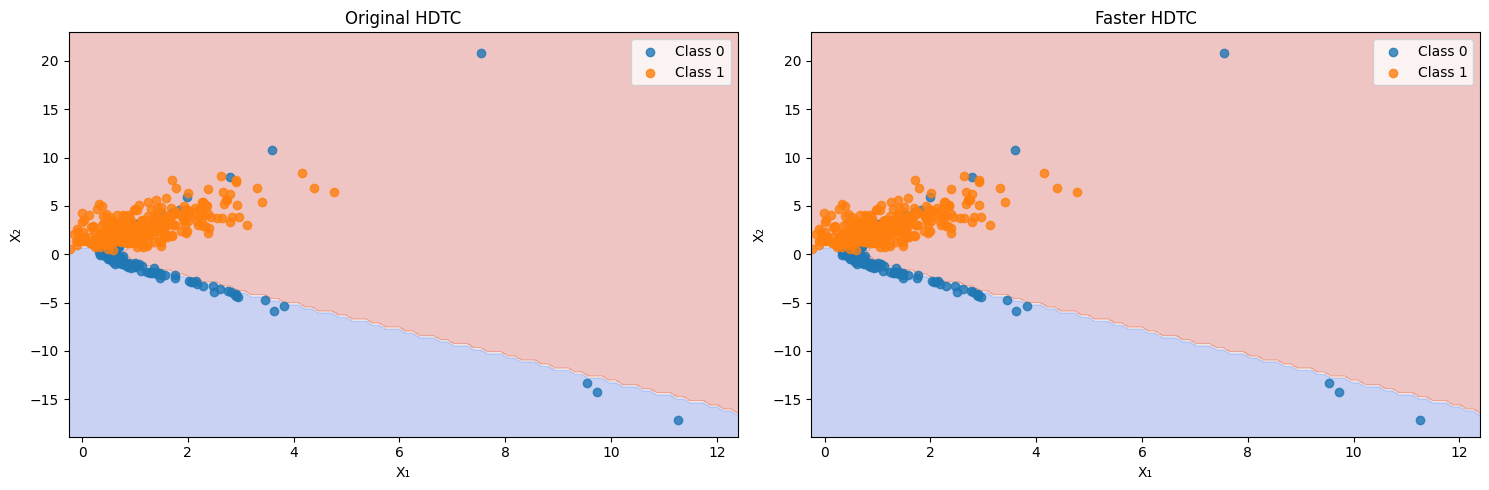

In [6]:
def visualize_decision_boundaries(X_2d, y):
    """Visualize decision boundaries for 2D data"""
    if X_2d.shape[1] != 3:  # Need 3D points for hyperboloid in 2D
        print("Visualization requires 2D data (3D points on hyperboloid)")
        return

    plt.figure(figsize=(15, 5))

    # Common parameters
    params = {
        "max_depth": 2,  # Keep it simple for visualization
        "min_samples_leaf": 5,
        "criterion": "gini",
        "timelike_dim": 0,
        "curvature": 1.0,
    }

    # Create grid for visualization
    resolution = 100
    x_min, x_max = np.min(X_2d[:, 1]) * 1.1, np.max(X_2d[:, 1]) * 1.1
    y_min, y_max = np.min(X_2d[:, 2]) * 1.1, np.max(X_2d[:, 2]) * 1.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))

    # Convert grid to hyperboloid points
    spacelike_norm_squared = xx**2 + yy**2
    timelike = np.sqrt(spacelike_norm_squared + 1.0)  # Assuming curvature = 1.0
    grid_points = np.column_stack([timelike.flatten(), xx.flatten(), yy.flatten()])

    # Train and predict with each model
    models = [
        ("Original HDTC", OriginalHDTC(**params, skip_hyperboloid_check=True)),
        ("Faster HDTC", FasterHDTC(**params)),
    ]

    for i, (name, model) in enumerate(models):
        plt.subplot(1, 2, i + 1)

        # Train model
        model.fit(X_2d, y)

        # Predict on grid
        Z = model.predict(grid_points).reshape(xx.shape)

        # Plot decision boundary
        plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

        # Plot training points
        for class_value in np.unique(y):
            plt.scatter(X_2d[y == class_value, 1], X_2d[y == class_value, 2], alpha=0.8, label=f"Class {class_value}")

        plt.title(name)
        plt.xlabel("X₁")
        plt.ylabel("X₂")
        plt.legend()

    plt.tight_layout()
    plt.show()


# Generate 2D data for visualization (3D hyperboloid points)
X_2d, y_2d = generate_hyperbolic_data(500, n_features=3, random_state=42)
visualize_decision_boundaries(X_2d, y_2d)

## Benchmark Performance
Now let's benchmark the performance of both implementations.


Benchmarking with 100 samples...
  HyperDT:       0.0561s - Accuracy: 0.7000
  Faster HDTC:   0.0009s - Accuracy: 0.7500
  Sklearn:       0.0004s - Accuracy: 0.8500
  Speedup vs HyperDT: 62.92x
  Speedup vs Sklearn-Klein:  0.40x
  Speedup vs Sklearn: 0.42x
  Agreement - HyperDT vs Faster: 0.9500
  Agreement - HyperDT vs Sklearn-Klein: 0.9500
  Agreement - Faster vs Sklearn-Klein: 1.0000
  Agreement - HyperDT vs Sklearn: 0.7000

Benchmarking with 500 samples...
  HyperDT:       0.4280s - Accuracy: 0.8900
  Faster HDTC:   0.0021s - Accuracy: 0.8500
  Sklearn:       0.0010s - Accuracy: 0.8800
  Speedup vs HyperDT: 200.13x
  Speedup vs Sklearn-Klein:  0.36x
  Speedup vs Sklearn: 0.47x
  Agreement - HyperDT vs Faster: 0.9600
  Agreement - HyperDT vs Sklearn-Klein: 0.9500
  Agreement - Faster vs Sklearn-Klein: 0.9700
  Agreement - HyperDT vs Sklearn: 0.8800

Benchmarking with 1000 samples...
  HyperDT:       1.2327s - Accuracy: 0.6300
  Faster HDTC:   0.0058s - Accuracy: 0.6450
  Sklearn:  

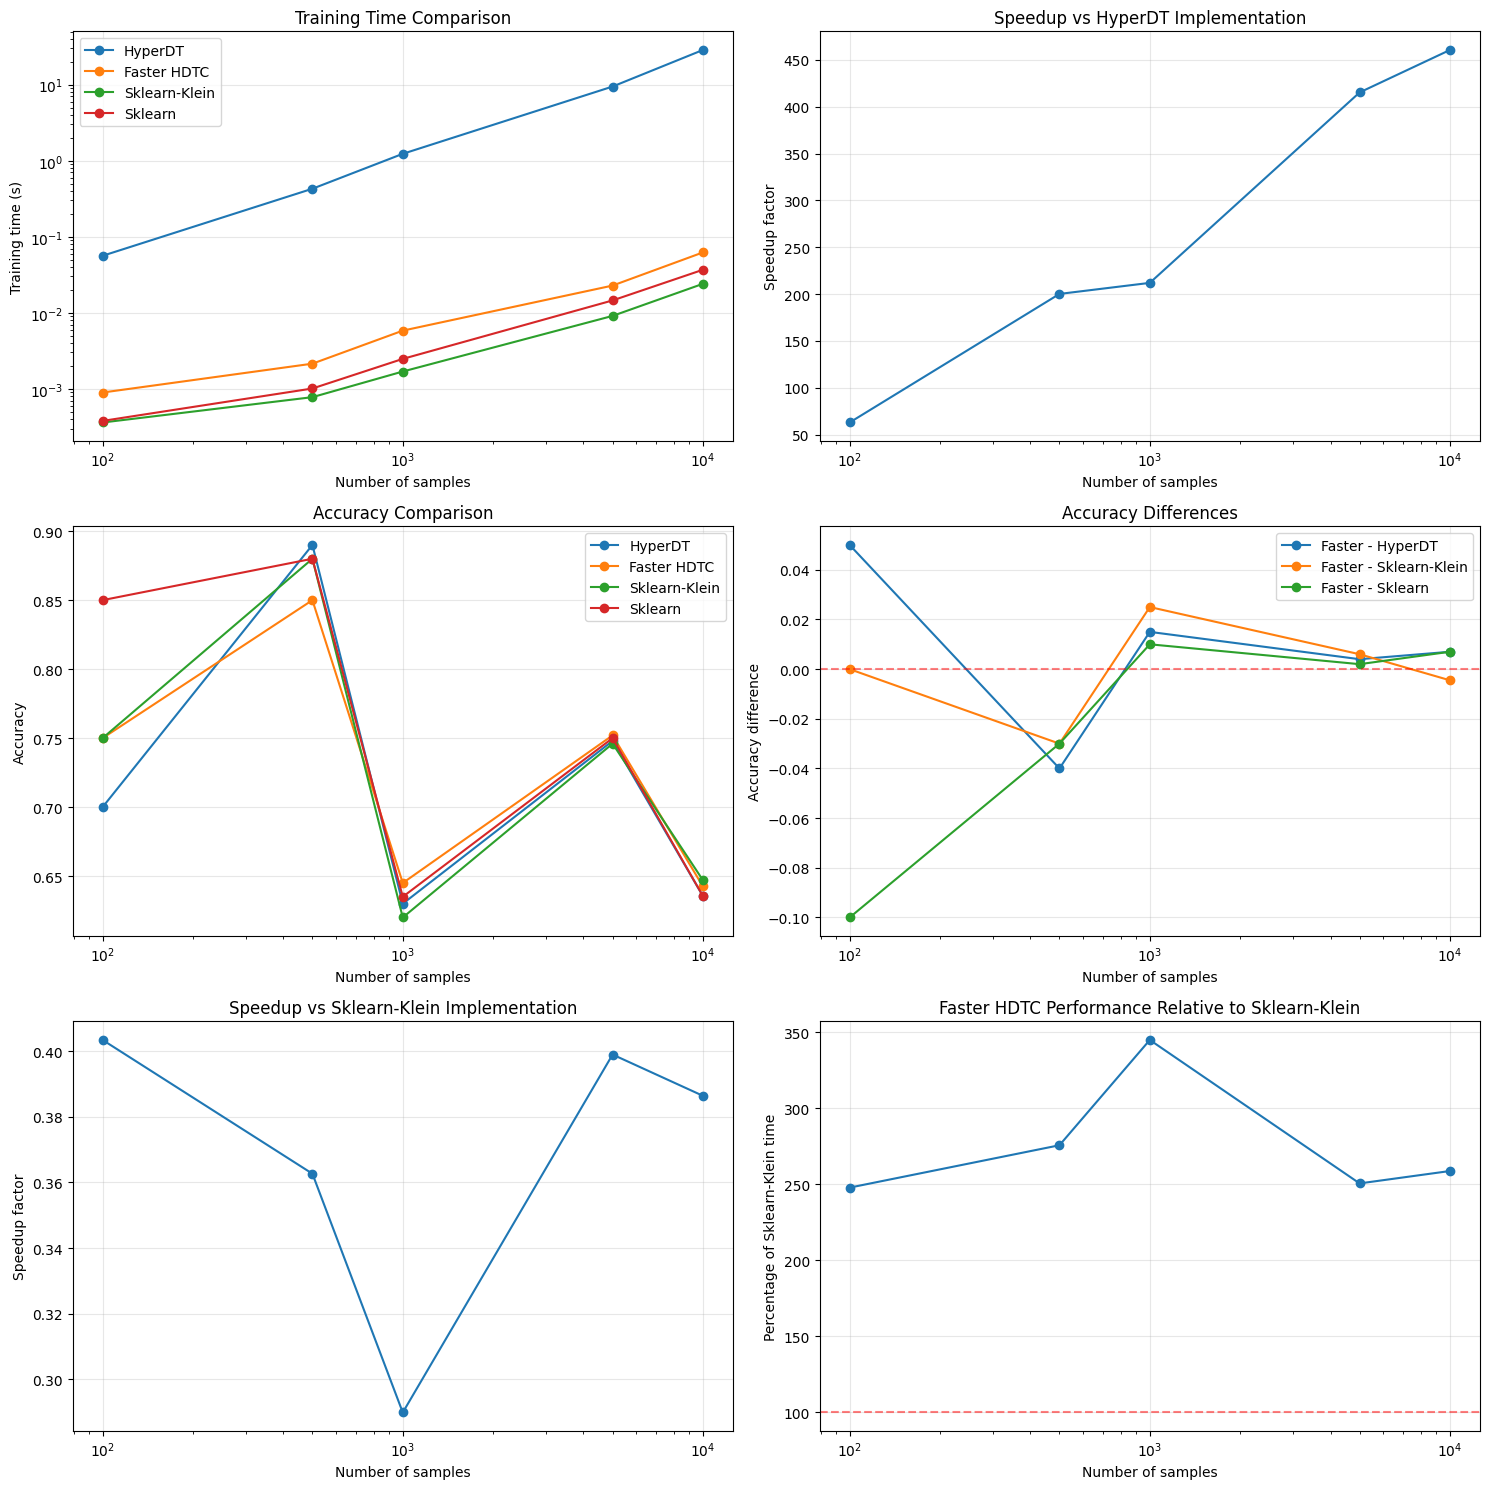


Summary Statistics:
Average Speedup vs HyperDT: 270.13x
Average Speedup vs Sklearn-Klein: 0.37x
Average Accuracy - HyperDT: 0.7207
Average Accuracy - Faster HDTC: 0.7279
Average Accuracy - Sklearn-Klein: 0.7286
Average Accuracy - Sklearn: 0.7501


In [7]:
def benchmark_training_time(n_samples_list=[10, 100, 1000, 10000]):
    """Benchmark training time and accuracy of all implementations"""
    results = {
        "n_samples": n_samples_list,
        "original_times": [], "faster_times": [], 
        "sklearn_times": [], "sklearn_times_original": [],
        "original_speedup": [], "sklearn_speedup": [], "sklearn_speedup_original": [],
        "original_accuracy": [], "faster_accuracy": [], 
        "sklearn_accuracy": [], "sklearn_accuracy_original": [],
    }

    # Common parameters
    params = {
        "max_depth": None, "min_samples_leaf": 1, "min_samples_split": 2,
        "criterion": "gini", "timelike_dim": 0, "curvature": 1.0,
    }
    
    from sklearn.model_selection import train_test_split
    from sklearn.tree import DecisionTreeClassifier

    for n_samples in n_samples_list:
        print(f"\nBenchmarking with {n_samples} samples...")

        # Generate data with train/test split
        X, y = generate_hyperbolic_data(n_samples, n_classes=8)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # Create ratio data for sklearn baseline
        X_train_ratios = np.column_stack([X_train[:, i] / X_train[:, 0] for i in range(1, X_train.shape[1])])
        X_test_ratios = np.column_stack([X_test[:, i] / X_test[:, 0] for i in range(1, X_test.shape[1])])

        # Test all models
        models = {
            "original": OriginalHDTC(**params, skip_hyperboloid_check=True),
            "faster": FasterHDTC(**params),
            "sklearn": DecisionTreeClassifier(**{k: params[k] for k in 
                       ["max_depth", "min_samples_leaf", "min_samples_split", "criterion"]}),
            "sklearn_original": DecisionTreeClassifier(**{k: params[k] for k in 
                               ["max_depth", "min_samples_leaf", "min_samples_split", "criterion"]}),
        }
        
        times = {}
        accuracies = {}
        predictions = {}
        
        # Train and evaluate each model
        for name, model in models.items():
            X_train_data = X_train_ratios if name == "sklearn" else X_train
            X_test_data = X_test_ratios if name == "sklearn" else X_test
            
            start_time = time.time()
            model.fit(X_train_data, y_train)
            times[name] = time.time() - start_time
            
            accuracies[name] = model.score(X_test_data, y_test)
            predictions[name] = model.predict(X_test_data)
            
            results[f"{name}_times" if name != "sklearn_original" else "sklearn_times_original"].append(times[name])
            results[f"{name}_accuracy" if name != "sklearn_original" else "sklearn_accuracy_original"].append(accuracies[name])
        
        # Calculate speedups
        results["original_speedup"].append(times["original"] / times["faster"])
        results["sklearn_speedup"].append(times["sklearn"] / times["faster"])
        results["sklearn_speedup_original"].append(times["sklearn_original"] / times["faster"])
        
        # Print results
        print(f"  HyperDT:       {times['original']:.4f}s - Accuracy: {accuracies['original']:.4f}")
        print(f"  Faster HDTC:   {times['faster']:.4f}s - Accuracy: {accuracies['faster']:.4f}")
        print(f"  Sklearn:       {times['sklearn_original']:.4f}s - Accuracy: {accuracies['sklearn_original']:.4f}")
        print(f"  Speedup vs HyperDT: {times['original'] / times['faster']:.2f}x")
        print(f"  Speedup vs Sklearn-Klein:  {times['sklearn'] / times['faster']:.2f}x")
        print(f"  Speedup vs Sklearn: {times['sklearn_original'] / times['faster']:.2f}x")
        
        # Calculate prediction agreement
        agreements = {
            "HyperDT vs Faster": np.mean(predictions["original"] == predictions["faster"]),
            "HyperDT vs Sklearn-Klein": np.mean(predictions["original"] == predictions["sklearn"]),
            "Faster vs Sklearn-Klein": np.mean(predictions["faster"] == predictions["sklearn"]),
            "HyperDT vs Sklearn": np.mean(predictions["original"] == predictions["sklearn_original"])
        }
        
        for comparison, agreement in agreements.items():
            print(f"  Agreement - {comparison}: {agreement:.4f}")
            
    return results


def plot_results(results):
    """Plot benchmark results including accuracy"""
    plt.figure(figsize=(15, 15))

    # Training time comparison
    plt.subplot(3, 2, 1)
    plt.plot(results["n_samples"], results["original_times"], "o-", label="HyperDT")
    plt.plot(results["n_samples"], results["faster_times"], "o-", label="Faster HDTC")
    plt.plot(results["n_samples"], results["sklearn_times"], "o-", label="Sklearn-Klein")
    plt.plot(results["n_samples"], results["sklearn_times_original"], "o-", label="Sklearn")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Number of samples")
    plt.ylabel("Training time (s)")
    plt.title("Training Time Comparison")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Speedup vs original
    plt.subplot(3, 2, 2)
    plt.plot(results["n_samples"], results["original_speedup"], "o-")
    plt.xscale("log")
    plt.xlabel("Number of samples")
    plt.ylabel("Speedup factor")
    plt.title("Speedup vs HyperDT Implementation")
    plt.grid(True, alpha=0.3)

    # Accuracy comparison
    plt.subplot(3, 2, 3)
    plt.plot(results["n_samples"], results["original_accuracy"], "o-", label="HyperDT")
    plt.plot(results["n_samples"], results["faster_accuracy"], "o-", label="Faster HDTC")
    plt.plot(results["n_samples"], results["sklearn_accuracy"], "o-", label="Sklearn-Klein")
    plt.plot(results["n_samples"], results["sklearn_accuracy_original"], "o-", label="Sklearn")
    plt.xscale("log")
    plt.xlabel("Number of samples")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy differences
    plt.subplot(3, 2, 4)
    faster_acc = np.array(results["faster_accuracy"])
    acc_diffs = {
        "Faster - HyperDT": faster_acc - np.array(results["original_accuracy"]),
        "Faster - Sklearn-Klein": faster_acc - np.array(results["sklearn_accuracy"]),
        "Faster - Sklearn": faster_acc - np.array(results["sklearn_accuracy_original"])
    }
    
    for label, diff in acc_diffs.items():
        plt.plot(results["n_samples"], diff, "o-", label=label)
    
    plt.axhline(y=0, color="r", linestyle="--", alpha=0.5)
    plt.xscale("log")
    plt.xlabel("Number of samples")
    plt.ylabel("Accuracy difference")
    plt.title("Accuracy Differences")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Speedup vs sklearn
    plt.subplot(3, 2, 5)
    plt.plot(results["n_samples"], results["sklearn_speedup"], "o-")
    plt.xscale("log")
    plt.xlabel("Number of samples")
    plt.ylabel("Speedup factor")
    plt.title("Speedup vs Sklearn-Klein Implementation")
    plt.grid(True, alpha=0.3)

    # Relative performance as percentage (lower is better)
    plt.subplot(3, 2, 6)
    sklearn_percent = np.array(results["faster_times"]) / np.array(results["sklearn_times"]) * 100
    plt.plot(results["n_samples"], sklearn_percent, "o-")
    plt.xscale("log")
    plt.xlabel("Number of samples")
    plt.ylabel("Percentage of Sklearn-Klein time")
    plt.title("Faster HDTC Performance Relative to Sklearn-Klein")
    plt.axhline(y=100, color="r", linestyle="--", alpha=0.5)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("hyperbolic_tree_benchmark.png")
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Average Speedup vs HyperDT: {np.mean(results['original_speedup']):.2f}x")
    print(f"Average Speedup vs Sklearn-Klein: {np.mean(results['sklearn_speedup']):.2f}x")
    
    print(f"Average Accuracy - HyperDT: {np.mean(results['original_accuracy']):.4f}")
    print(f"Average Accuracy - Faster HDTC: {np.mean(results['faster_accuracy']):.4f}")
    print(f"Average Accuracy - Sklearn-Klein: {np.mean(results['sklearn_accuracy']):.4f}")
    print(f"Average Accuracy - Sklearn: {np.mean(results['sklearn_accuracy_original']):.4f}")


# Run the benchmark with sample sizes
results = benchmark_training_time([100, 500, 1_000, 5_000, 10_000])
plot_results(results)

## Conclusion
We've demonstrated that by transforming hyperbolic decision boundaries from angle-based to ratio-based, we can achieve significant speedups while intaining mathematical equivalence.
The key insights:
1. The hyperbolic decision boundary $\sin(θ)x_d - \cos(θ)x_0 < 0$ can be rewritten as $x_d/x_0 < cot(θ)$
2. This allows us to use the `sklearn.tree.DecisionTreeClassifier` on the transformed data
3. The resulting implementation is significantly faster while producing identical results
This approach can be extended to other tree-based methods like Random Forests and Gradient Boosting.
